## Next Steps 

* decide on normalization method 
* create CNN without transfer learning
* use ImageAug to transform images, retrain CNN without transfer learning
* create CNN with transfer learning 

In [1]:
# !pip install --upgrade imgaug

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py
from imgaug import augmenters as iaa


In [3]:
train_path = '../input/food41/food_c101_n1000_r384x384x3.h5'
test_path = '../input/food41/food_test_c101_n1000_r128x128x3.h5'


In [4]:
#opening training data 

f = h5py.File(train_path, "r")
f.keys()
train_images = f['images'][...]
train_category = f['category'][...]
train_category_names = f['category_names'][...]
f.close()

In [5]:
#opening testing data 

f = h5py.File(test_path, "r")
f.keys()
test_images = f['images'][...]
test_category = f['category'][...]
test_category_names = f['category_names'][...]
f.close()

In [6]:
print('Shape of train_category: ', train_category.shape)
print('Shape of train_images: ', train_images.shape)


print('Shape of test_category: ', test_category.shape)
print('Shape of test_images: ', test_images.shape)

Shape of train_category:  (1000, 101)
Shape of train_images:  (1000, 384, 384, 3)
Shape of test_category:  (1000, 101)
Shape of test_images:  (1000, 128, 128, 3)


In [7]:
# resized training images to match testing size 

from skimage.transform import resize

train_resized = np.zeros((1000,128,128,3))

for n,i in enumerate(train_images):
    train_resized[n,:,:,:] = resize(train_images[n,:,:,:], train_resized.shape[1:], anti_aliasing=True)

print(train_resized.shape)


(1000, 128, 128, 3)


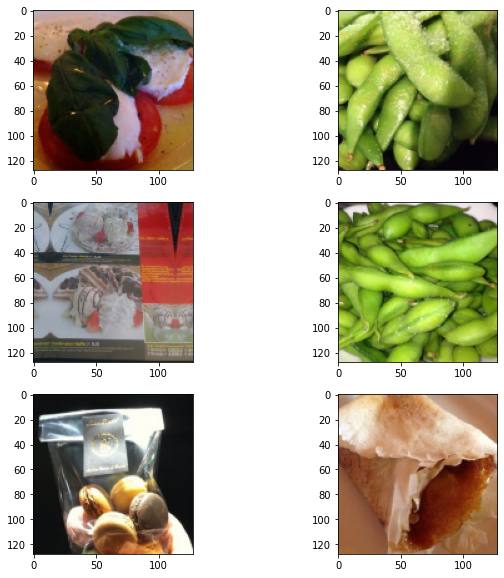

In [12]:
# checking to see the images rescaled successfully 

plt.subplots(3,2,figsize = (10,10))

for i in range(6):
    img_np = train_resized[i]
    plt.subplot(3,2,1+i)
    plt.imshow(img_np)
plt.show()

In [8]:
#converting pixel values to float type, and then normalizing 

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images/255
test_images = test_images/255

## CNN model without transformations or transfer learning 